In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import utm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pykrige.ok import OrdinaryKriging

import contextily as ctx
from scipy import stats
from ngl_tools import smt
from regional_K.cpt_functions import setup_cpt, calc_SBT, soil_stress, detect_change_points, k_from_Ic, setup_grid, solve_Ic, SBT_from_Ic, ms_layer_assignment, msaf_layer_assignment

import warnings
warnings.filterwarnings("ignore")

In [3]:
## setup cpt data 
cpt = setup_cpt('./USGS_CPT_data/')
## fill any missing water depths with the median
default_dGWT = np.nanmedian([cpt[bh]['Water depth'] for bh in cpt if not np.isnan(cpt[bh]['Water depth'])])
for bh in cpt:
    if np.isnan(cpt[bh]['Water depth']):
        cpt[bh]['Water depth'] = default_dGWT
cpt = soil_stress(cpt)
calc_SBT(cpt)

for _, data in cpt.items():
    data['CPT_data']['I_c'] = solve_Ic(data['CPT_data']['q_c'], data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'], data['CPT_data']['f_s'])
    qt_inv, fs_inv, _ = smt.cpt_inverse_filter(np.array(data['CPT_data']['q_c']), np.array(data['CPT_data']['d']), fs=data['CPT_data']['f_s'], sigmav=data['CPT_data']['sig_v'], sigmavp=data['CPT_data']['sig_prime_v'])
    Ic_inv, _, _ = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'])
    data['CPT_data']['I_c_inv'] = Ic_inv
    data['SBT_inv'],_ = SBT_from_Ic(Ic_inv)
    data['k_fromIc_inv'] = k_from_Ic(Ic_inv)
    data['CPT_data']['k_fromIc'] = k_from_Ic(data['CPT_data']['I_c'])

shapefile_path = './deposits_shp/sfq2py.shp'
data = gpd.read_file(shapefile_path)
data.crs = 'EPSG:4326'
cpts_df = pd.DataFrame.from_dict(cpt, orient='index')
cpts_df.drop(['CPT_data'], axis=1, inplace=True)
cpts_gdf = gpd.GeoDataFrame(cpts_df, geometry=gpd.points_from_xy(cpts_df['Lon'], cpts_df['Lat']))
cpts_gdf.crs = 'EPSG:4326'
joined = gpd.sjoin(cpts_gdf, data, how='left')

cgs_data = pd.read_csv('./cgs_bhs_0/CGSBoreholeDB_BoreholeLocations.csv')
lith = pd.read_csv('./cgs_bhs_0/lithology.csv')
lith = lith[lith['remarks'].str.contains('fill', case=False, na=False)]
lith = lith.merge(cgs_data[['well_name', 'latitude', 'longitude']], on='well_name', how='left')
lith_gdf = gpd.GeoDataFrame(lith, geometry=gpd.points_from_xy(lith.longitude, lith.latitude),crs='EPSG:4326')
lith_gdf['Fill'] = lith_gdf['bottom_depth'] * 0.3048 # convert to meters
lith = lith[lith.index != 64] ## drop the 64 from the lith data index, it said 'filled' and was not artificial fill.
lith_gdf = lith_gdf[lith_gdf.index != 64]
lith_gdf['UTM -X'], lith_gdf['UTM -Y'] = zip(*[utm.from_latlon(lat, lon)[:2] for lat, lon in zip(lith_gdf['latitude'], lith_gdf['longitude'])])

points = setup_grid(geoplot='./geojson/alameda_city.geojson')  # run for just the cases on the island
points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')
points = points.dropna(subset=['utmX', 'utmY'])

### Run the layers to get k values from each modeling setup

In [4]:
preprocess = False
layers_dict = {}
results_k_values = {}

a = 1
b = 20

for bh in cpt:
    df = cpt[bh]['CPT_data']
    depth = cpt[bh]['CPT_data']['d'].values
    fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
    if preprocess:
        SBT = cpt[bh]['SBT_inv']
        logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
    else:
        SBT = cpt[bh]['SBT']
        logKh = np.log(df['k_fromIc']*86400).clip(-5)

    change_points = detect_change_points(SBT, model="l2", penalty=a*(max(cpt[bh]['CPT_data']['d']) -12) + b)[:-1]
    change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
    depths = []
    Ks = []
    SBTs = []
    for cp_ind in range(len(change_points) - 1):
        start_idx = change_points[cp_ind]
        end_idx = change_points[cp_ind + 1]

        avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
        avg_SBT = stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0]  # here also ['CPT_data'] for corrected data
        start_depth = cpt[bh]['CPT_data']['d'][start_idx]
        end_depth = cpt[bh]['CPT_data']['d'][end_idx]
        SBTs.append(avg_SBT)
        depths.append(end_depth - start_depth)
        Ks.append(avg_k_fromIc)
    ## now assign layers using MS method
    layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)
    layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
    layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']
    fill_thickness = layers_dict[bh]['Fill']
    ybm_thickness = layers_dict[bh]['Young Bay Mud']
    ms_thickness = layers_dict[bh]['Merritt Sand']
    fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
    ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
    ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
    if preprocess:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
        results_k_values[bh]['Fill'] = fill_values.mean()
        ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
        ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
        below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean()
    else:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
        ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
        ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
        below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
    # Transform data to log scale
results_k_values = pd.DataFrame(results_k_values).transpose()
results_k_m_day = results_k_values.apply(lambda x: x*86400)
# log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
layers_df = pd.DataFrame.from_dict(layers_dict, orient='index')
# layers_df.to_csv('new_sand_cp_layers.csv')

In [5]:
# assign the values from results_k_m_day to cpt_gdf
cpts_gdf['AF_K_CP_MS'] = results_k_m_day['Fill']
cpts_gdf['YBM_K_CP_MS'] = results_k_m_day['Young Bay Mud']
cpts_gdf['MS_K_CP_MS'] = results_k_m_day['Merritt Sand']
cpts_gdf['YB_K_CP_MS'] = results_k_m_day['Yerba Buena Mud']

In [14]:
## make sure all fonts on a plot are 14
plt.rcParams.update({'font.size': 12})


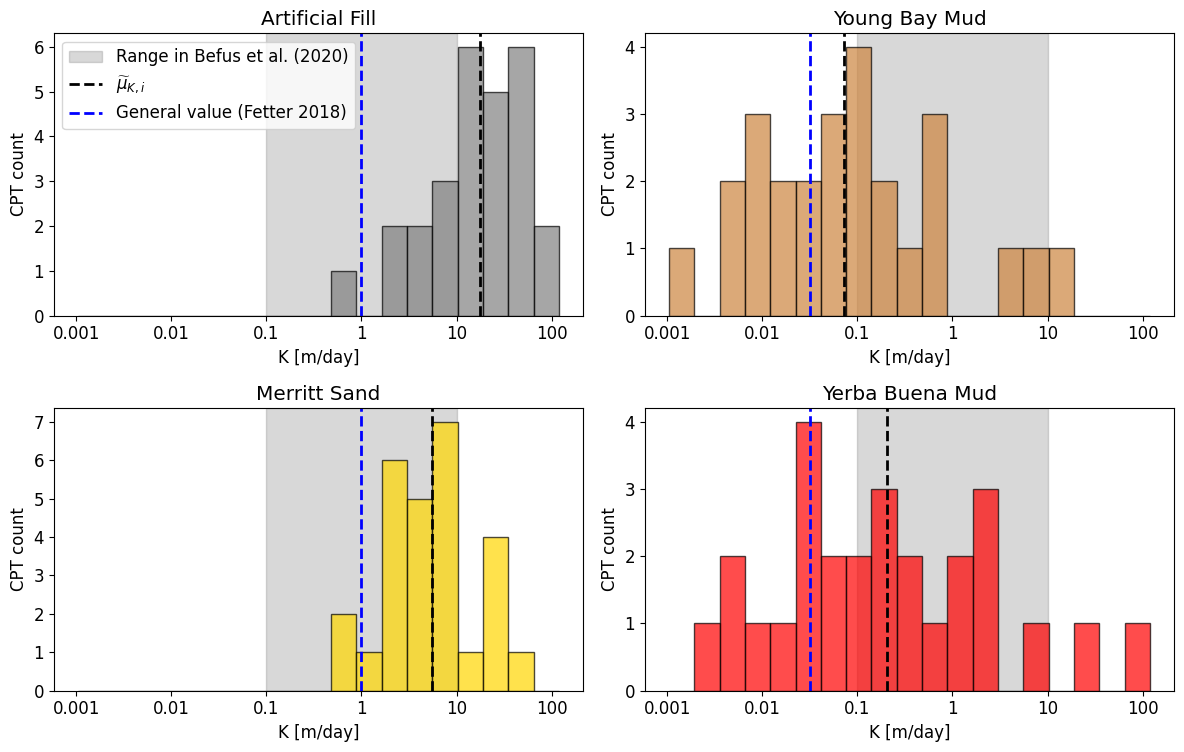

In [18]:
# Histograms of K values for each layer
log_results_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)

# Define linear bins in log-transformed space
min_value = log_results_df.min().min()
max_value = log_results_df.max().max()
bins = np.linspace(min_value, max_value, 20)  # 20 linear bins in log-transformed space

# table values: Fill, Young Bay Mud, Merritt Sand, Yerba Buena Mud
custom_values = [0,-1.5,0,-1.5] 

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Yerba Buena Mud']
colors = ['grey', 'peru', 'gold', 'red']
for i, (ax, layer) in enumerate(zip(axes.flatten(), layer_names)):
    # Calculate mean for the layer (ignoring NaN values)
    layer_data = log_results_df[layer].dropna()
    mean_value = layer_data.median()
    ax.axvspan(np.log10(0.1), np.log10(10), color='grey', alpha=0.3, label='Range in Befus et al. (2020)')
    ax.hist(layer_data, bins=bins, color=colors[i], alpha = 0.7, edgecolor='black')
    if i == 0:
        ax.set_title('Artificial Fill')
    else:
        ax.set_title(f'{layer}')
    ax.set_xlabel('K [m/day]')
    ax.set_ylabel('CPT count')
    # Plot vertical dashed line for the mean
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=2, label='$\widetilde{\mu}_{K,i}$')
    if custom_values:
        ax.axvline(custom_values[i], color='blue', linestyle='--', linewidth=2, label='General value (Fetter 2018)')
    ticks = ax.get_xticks()  # Get the current ticks in log scale
    ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    if i == 0:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle

plt.savefig('./figures/k_hist_CPMS.png', format='png', dpi=1000, bbox_inches='tight')
plt.savefig('./figures/k_hist_CPMS.pdf', format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


In [16]:
## now run and save hudson MS and hudson MSAF

preprocess = False
layers_dict = {}
results_k_values = {}
for bh in cpt:
    df = cpt[bh]['CPT_data']
    dGWT = cpt[bh]['Water depth']
    depth = cpt[bh]['CPT_data']['d'].values
    fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
    if np.isnan(dGWT):
        # continue
        # print(df)
        dGWT = 1
    if preprocess:
        SBT, _ = cpt[bh]['SBT_inv']
        logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
    else:
        SBT = cpt[bh]['SBT']
        logKh = np.log(df['k_fromIc']*86400).clip(-5)
    ztop, zbot, _, _ = smt.cpt_layering(np.array(SBT), np.array(logKh), depth, dGWT=dGWT, tref=5, Nmax=None)
    SBTs = []
    Ks = []
    for indx in range(len(ztop)):
        start_idx = np.where(depth >= ztop[indx])[0][0]
        end_idx = np.where(depth >= zbot[indx])[0][0]
        SBTs.append(stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0])
        Ks.append(cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean())
    depths = zbot - ztop
    layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)
    layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
    layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']

    fill_thickness = layers_dict[bh]['Fill']
    ybm_thickness = layers_dict[bh]['Young Bay Mud']
    ms_thickness = layers_dict[bh]['Merritt Sand']
    fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
    ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
    ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
    if preprocess:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
        results_k_values[bh]['Fill'] = fill_values.mean()
        ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
        ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
        below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean()
    else:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
        ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
        ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
        below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
    # Transform data to log scale
results_k_values = pd.DataFrame(results_k_values).transpose()
results_k_m_day = results_k_values.apply(lambda x: x*86400)
log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
layers_df = pd.DataFrame.from_dict(layers_dict, orient='index')
# layers_df.to_csv('hudson_ms_layers.csv')

# assign the values from results_k_m_day to cpt_gdf
cpts_gdf['AF_K_AC_MS'] = results_k_m_day['Fill']
cpts_gdf['YBM_K_AC_MS'] = results_k_m_day['Young Bay Mud']
cpts_gdf['MS_K_AC_MS'] = results_k_m_day['Merritt Sand']
cpts_gdf['YB_K_AC_MS'] = results_k_m_day['Yerba Buena Mud']

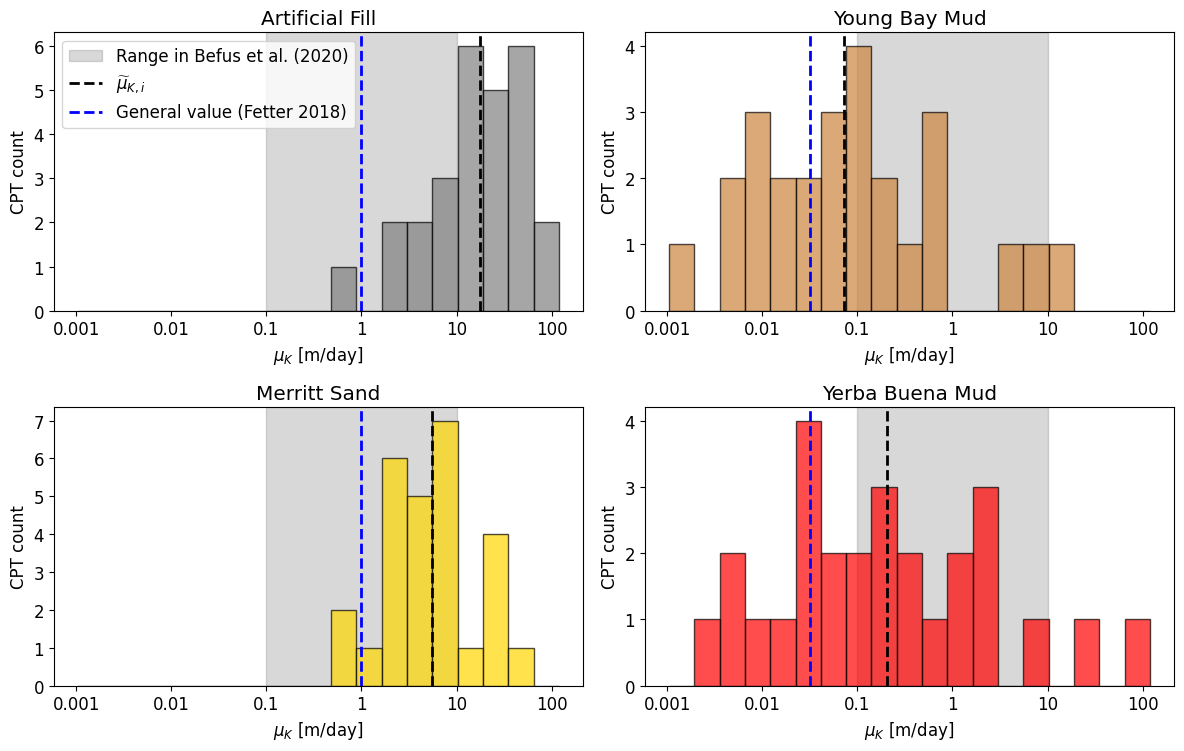

In [17]:
# Histograms of K values for each layer
log_results_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)

# Define linear bins in log-transformed space
min_value = log_results_df.min().min()
max_value = log_results_df.max().max()
bins = np.linspace(min_value, max_value, 20)  # 20 linear bins in log-transformed space

# table values: Fill, Young Bay Mud, Merritt Sand, Yerba Buena Mud
custom_values = [0,-1.5,0,-1.5] 

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Yerba Buena Mud']
colors = ['grey', 'peru', 'gold', 'red']
for i, (ax, layer) in enumerate(zip(axes.flatten(), layer_names)):
    # Calculate mean for the layer (ignoring NaN values)
    layer_data = log_results_df[layer].dropna()
    mean_value = layer_data.median()
    ax.axvspan(np.log10(0.1), np.log10(10), color='grey', alpha=0.3, label='Range in Befus et al. (2020)')
    ax.hist(layer_data, bins=bins, color=colors[i], alpha = 0.7, edgecolor='black')
    if i == 0:
        ax.set_title('Artificial Fill')
    else:
        ax.set_title(f'{layer}')
    ax.set_xlabel('$\mu_{K}$ [m/day]')
    ax.set_ylabel('CPT count')
    # Plot vertical dashed line for the mean
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=2, label='$\widetilde{\mu}_{K,i}$')
    if custom_values:
        ax.axvline(custom_values[i], color='blue', linestyle='--', linewidth=2, label='General value (Fetter 2018)')
    ticks = ax.get_xticks()  # Get the current ticks in log scale
    ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
    if i == 0:
        ax.legend()
    # make sure y ticks are only integers
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle

plt.savefig('./figures/k_hist_hudMS.png', format='png', dpi=1000)
plt.savefig('./figures/k_hist_hudMS.pdf', format='pdf', dpi=1000)
plt.show()


In [8]:
## now run and save hudson MS and hudson MSAF

preprocess = False
layers_dict = {}
results_k_values = {}
for bh in cpt:
    df = cpt[bh]['CPT_data']
    dGWT = cpt[bh]['Water depth']
    depth = cpt[bh]['CPT_data']['d'].values
    fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
    if np.isnan(dGWT):
        # continue
        # print(df)
        dGWT = 1
    if preprocess:
        SBT, _ = cpt[bh]['SBT_inv']
        logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
    else:
        SBT = cpt[bh]['SBT']
        logKh = np.log(df['k_fromIc']*86400).clip(-5)
    ztop, zbot, _, _ = smt.cpt_layering(np.array(SBT), np.array(logKh), depth, dGWT=dGWT, tref=5, Nmax=None)
    SBTs = []
    Ks = []
    for indx in range(len(ztop)):
        start_idx = np.where(depth >= ztop[indx])[0][0]
        end_idx = np.where(depth >= zbot[indx])[0][0]
        SBTs.append(stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0])
        Ks.append(cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean())
    depths = zbot - ztop
    layers_dict[bh] = msaf_layer_assignment(depths, SBTs, fill_flag)
    layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
    layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']

    fill_thickness = layers_dict[bh]['Fill']
    ybm_thickness = layers_dict[bh]['Young Bay Mud']
    ms_thickness = layers_dict[bh]['Merritt Sand']
    fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
    ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
    ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
    if preprocess:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
        results_k_values[bh]['Fill'] = fill_values.mean()
        ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
        ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
        below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean()
    else:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
        ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
        ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
        below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
    # Transform data to log scale
results_k_values = pd.DataFrame(results_k_values).transpose()
results_k_m_day = results_k_values.apply(lambda x: x*86400)
log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
layers_df = pd.DataFrame.from_dict(layers_dict, orient='index')
# layers_df.to_csv('hudson_msaf_layers.csv')

# assign the values from results_k_m_day to cpt_gdf
cpts_gdf['AF_K_AC_MSAF'] = results_k_m_day['Fill']
cpts_gdf['YBM_K_AC_MSAF'] = results_k_m_day['Young Bay Mud']
cpts_gdf['MS_K_AC_MSAF'] = results_k_m_day['Merritt Sand']
cpts_gdf['YB_K_AC_MSAF'] = results_k_m_day['Yerba Buena Mud']

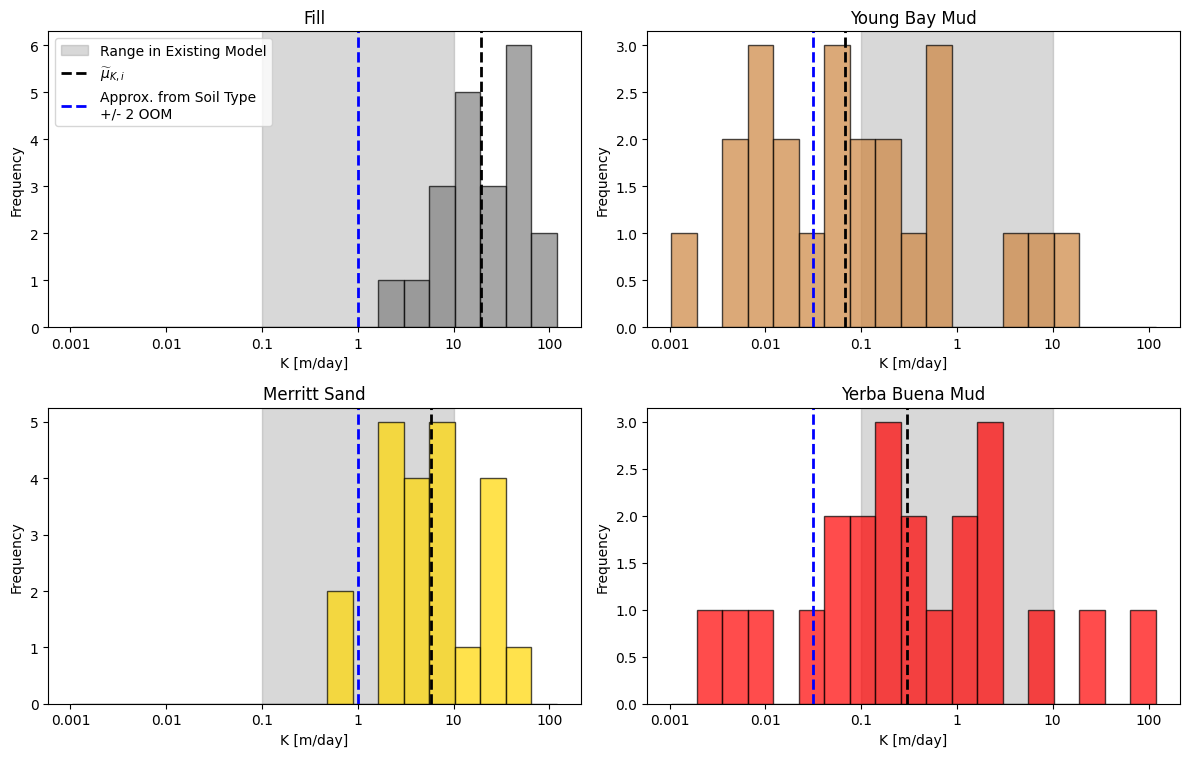

In [9]:
# Histograms of K values for each layer
log_results_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)

# Define linear bins in log-transformed space
min_value = log_results_df.min().min()
max_value = log_results_df.max().max()
bins = np.linspace(min_value, max_value, 20)  # 20 linear bins in log-transformed space

# table values: Fill, Young Bay Mud, Merritt Sand, Yerba Buena Mud
custom_values = [0,-1.5,0,-1.5] 

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Yerba Buena Mud']
colors = ['grey', 'peru', 'gold', 'red']
for i, (ax, layer) in enumerate(zip(axes.flatten(), layer_names)):
    # Calculate mean for the layer (ignoring NaN values)
    layer_data = log_results_df[layer].dropna()
    mean_value = layer_data.median()
    ax.axvspan(np.log10(0.1), np.log10(10), color='grey', alpha=0.3, label='Range in Existing Model')
    ax.hist(layer_data, bins=bins, color=colors[i], alpha = 0.7, edgecolor='black')
    ax.set_title(f'{layer}')
    ax.set_xlabel('K [m/day]')
    ax.set_ylabel('Frequency')
    # Plot vertical dashed line for the mean
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=2, label='$\widetilde{\mu}_{K,i}$')
    if custom_values:
        ax.axvline(custom_values[i], color='blue', linestyle='--', linewidth=2, label='Approx. from Soil Type \n+/- 2 OOM')
    ticks = ax.get_xticks()  # Get the current ticks in log scale
    ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
    if i == 0:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.savefig('./figures/k_hist_hudMSAF.png', format='png', dpi=1000)
plt.savefig('./figures/k_hist_hudMSAF.pdf', format='pdf', dpi=1000)

plt.show()


In [10]:
preprocess = False
layers_dict = {}
results_k_values = {}

a = 1
b = 20

for bh in cpt:
    df = cpt[bh]['CPT_data']
    depth = cpt[bh]['CPT_data']['d'].values
    fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
    if preprocess:
        SBT = cpt[bh]['SBT_inv']
        logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
    else:
        SBT = cpt[bh]['SBT']
        logKh = np.log(df['k_fromIc']*86400).clip(-5)

    change_points = detect_change_points(SBT, model="l2", penalty=a*(max(cpt[bh]['CPT_data']['d']) -12) + b)[:-1]
    change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
    depths = []
    Ks = []
    SBTs = []
    for cp_ind in range(len(change_points) - 1):
        start_idx = change_points[cp_ind]
        end_idx = change_points[cp_ind + 1]

        avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
        avg_SBT = stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0]  # here also ['CPT_data'] for corrected data
        start_depth = cpt[bh]['CPT_data']['d'][start_idx]
        end_depth = cpt[bh]['CPT_data']['d'][end_idx]
        SBTs.append(avg_SBT)
        depths.append(end_depth - start_depth)
        Ks.append(avg_k_fromIc)
    ## now assign layers using MS method
    layers_dict[bh] = msaf_layer_assignment(depths, SBTs, fill_flag)
    layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
    layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']
    fill_thickness = layers_dict[bh]['Fill']
    ybm_thickness = layers_dict[bh]['Young Bay Mud']
    ms_thickness = layers_dict[bh]['Merritt Sand']
    fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
    ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
    ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
    if preprocess:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
        results_k_values[bh]['Fill'] = fill_values.mean()
        ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
        ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
        below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean()
    else:
        results_k_values[bh] = {}
        fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
        ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
        ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
        below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
    # Transform data to log scale
results_k_values = pd.DataFrame(results_k_values).transpose()
results_k_m_day = results_k_values.apply(lambda x: x*86400)
# log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
layers_df = pd.DataFrame.from_dict(layers_dict, orient='index')
# layers_df.to_csv('new_msaf_cp_layers.csv')

# assign the values from results_k_m_day to cpt_gdf
cpts_gdf['AF_K_CP_MSAF'] = results_k_m_day['Fill']
cpts_gdf['YBM_K_CP_MSAF'] = results_k_m_day['Young Bay Mud']
cpts_gdf['MS_K_CP_MSAF'] = results_k_m_day['Merritt Sand']
cpts_gdf['YB_K_CP_MSAF'] = results_k_m_day['Yerba Buena Mud']

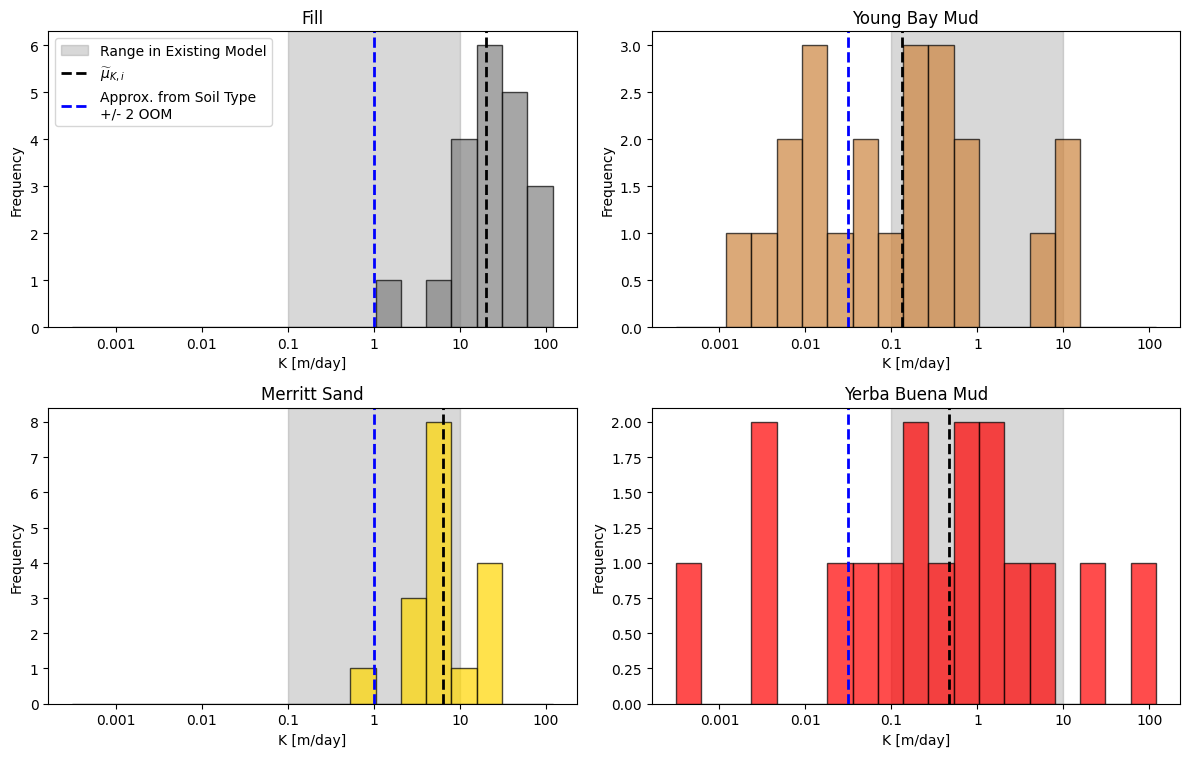

In [11]:
# Histograms of K values for each layer
log_results_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)

# Define linear bins in log-transformed space
min_value = log_results_df.min().min()
max_value = log_results_df.max().max()
bins = np.linspace(min_value, max_value, 20)  # 20 linear bins in log-transformed space

# table values: Fill, Young Bay Mud, Merritt Sand, Yerba Buena Mud
custom_values = [0,-1.5,0,-1.5] 

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Yerba Buena Mud']
colors = ['grey', 'peru', 'gold', 'red']
for i, (ax, layer) in enumerate(zip(axes.flatten(), layer_names)):
    # Calculate mean for the layer (ignoring NaN values)
    layer_data = log_results_df[layer].dropna()
    mean_value = layer_data.median()
    ax.axvspan(np.log10(0.1), np.log10(10), color='grey', alpha=0.3, label='Range in Existing Model')
    ax.hist(layer_data, bins=bins, color=colors[i], alpha = 0.7, edgecolor='black')
    ax.set_title(f'{layer}')
    ax.set_xlabel('K [m/day]')
    ax.set_ylabel('Frequency')
    # Plot vertical dashed line for the mean
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=2, label='$\widetilde{\mu}_{K,i}$')
    if custom_values:
        ax.axvline(custom_values[i], color='blue', linestyle='--', linewidth=2, label='Approx. from Soil Type \n+/- 2 OOM')
    ticks = ax.get_xticks()  # Get the current ticks in log scale
    ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
    if i == 0:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.savefig('./figures/k_hist_CPMSAF.png', format='png', dpi=1000)
plt.savefig('./figures/k_hist_CPMSAF.pdf', format='pdf', dpi=1000)

plt.show()


##### Heuristic

In [12]:
layers = pd.read_csv('./layer_thicknesses.csv', index_col=0)
results_k_values = {}
layers_dict = {}
for _,row in layers.iterrows():  # [layers['Filename'].str.startswith('ALC')]
    fill_thickness = row['Fill']
    ybm_thickness = row['Young Bay Mud']
    ms_thickness = row['Merrit sand']
    fill_depth = fill_thickness
    ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
    ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
    bh = row['Filename']
    layers_dict[bh] = {'Fill': fill_thickness, 'Young Bay Mud': ybm_thickness, 'Merritt Sand': ms_thickness}
    if bh in cpt:
        if preprocess:
            results_k_values[bh] = {}
            fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
            results_k_values[bh]['Fill'] = fill_values.mean()
            ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
            results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
            ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
            results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
            below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
            results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean()
        else:
            results_k_values[bh] = {}
            fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
            results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
            ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
            results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
            ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
            results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
            below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
            results_k_values[bh]['Yerba Buena Mud'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
results_k_values = pd.DataFrame(results_k_values).transpose()
results_k_m_day = results_k_values.apply(lambda x: x*86400)
log_results_k_df = results_k_m_day.map(lambda x: np.log10(x) if x > 0 else np.nan) 

# assign the values from results_k_m_day to cpt_gdf
cpts_gdf['AF_K_heur'] = results_k_m_day['Fill']
cpts_gdf['YBM_K_heur'] = results_k_m_day['Young Bay Mud']
cpts_gdf['MS_K_heur'] = results_k_m_day['Merritt Sand']
cpts_gdf['YB_K_heur'] = results_k_m_day['Yerba Buena Mud']

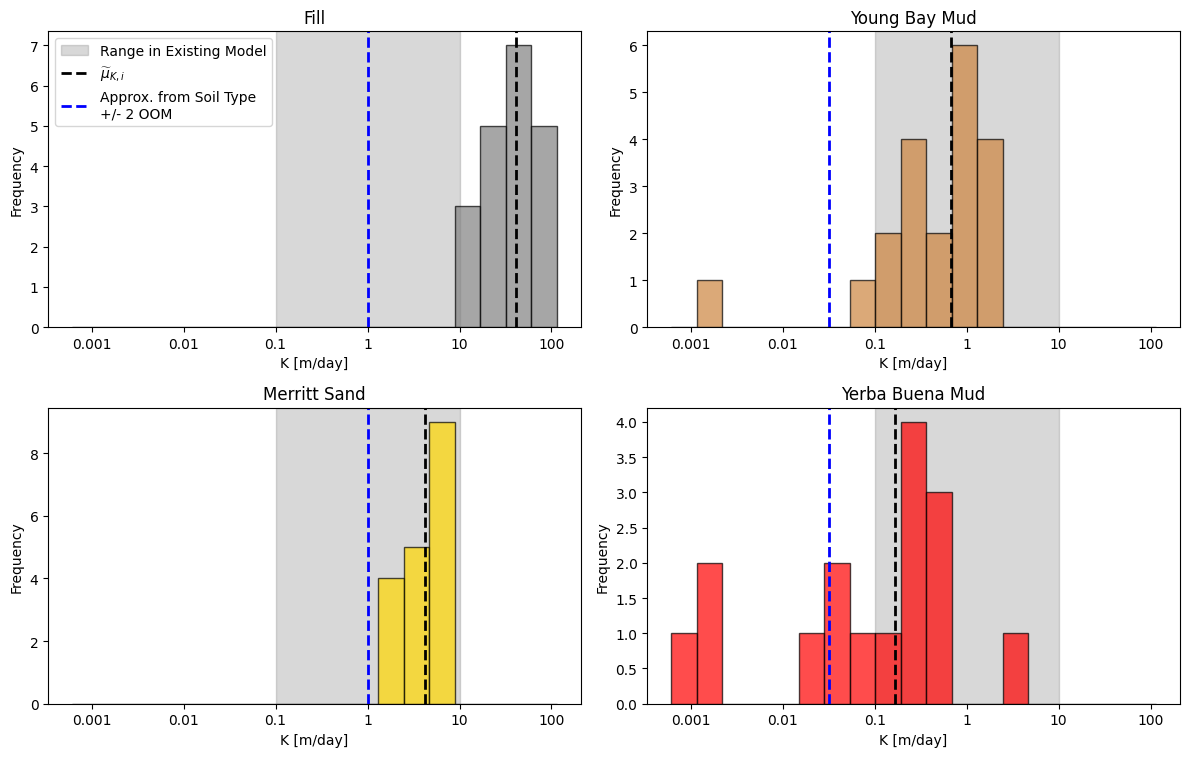

In [13]:
# Histograms of K values for each layer
log_results_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)

# Define linear bins in log-transformed space
min_value = log_results_df.min().min()
max_value = log_results_df.max().max()
bins = np.linspace(min_value, max_value, 20)  # 20 linear bins in log-transformed space

# table values: Fill, Young Bay Mud, Merritt Sand, Yerba Buena Mud
custom_values = [0,-1.5,0,-1.5] 

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Yerba Buena Mud']
colors = ['grey', 'peru', 'gold', 'red']
for i, (ax, layer) in enumerate(zip(axes.flatten(), layer_names)):
    # Calculate mean for the layer (ignoring NaN values)
    layer_data = log_results_df[layer].dropna()
    mean_value = layer_data.median()
    ax.axvspan(np.log10(0.1), np.log10(10), color='grey', alpha=0.3, label='Range in Existing Model')
    ax.hist(layer_data, bins=bins, color=colors[i], alpha = 0.7, edgecolor='black')
    ax.set_title(f'{layer}')
    ax.set_xlabel('K [m/day]')
    ax.set_ylabel('Frequency')
    # Plot vertical dashed line for the mean
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=2, label='$\widetilde{\mu}_{K,i}$')
    if custom_values:
        ax.axvline(custom_values[i], color='blue', linestyle='--', linewidth=2, label='Approx. from Soil Type \n+/- 2 OOM')
    ticks = ax.get_xticks()  # Get the current ticks in log scale
    ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
    if i == 0:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle

plt.savefig('./figures/k_hist_heur.png', format='png', dpi=1000)
plt.savefig('./figures/k_hist_heur.pdf', format='pdf', dpi=1000)
plt.show()


### Now, explore the spatial variation of K values within fill and YBM, and check for any spatial patterning

Text(0.5, 1.0, 'K values for YBM layer using CP-MSAF method')

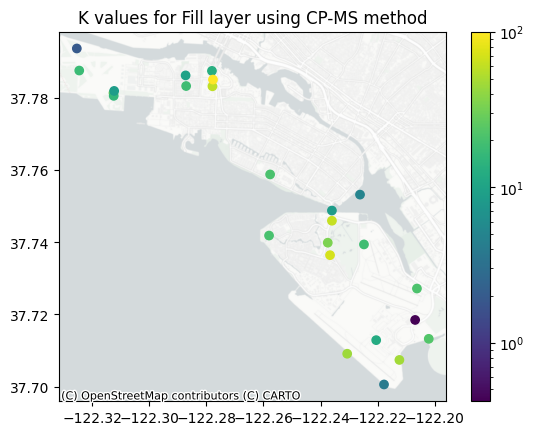

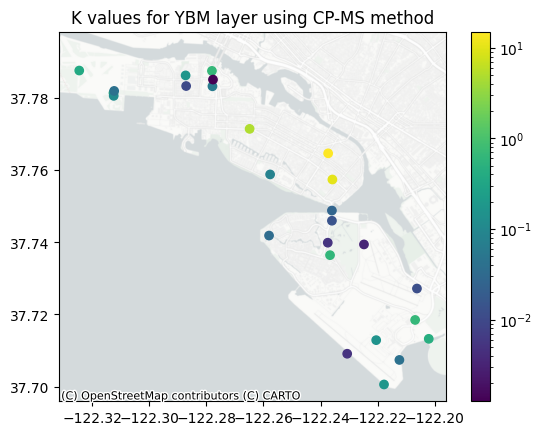

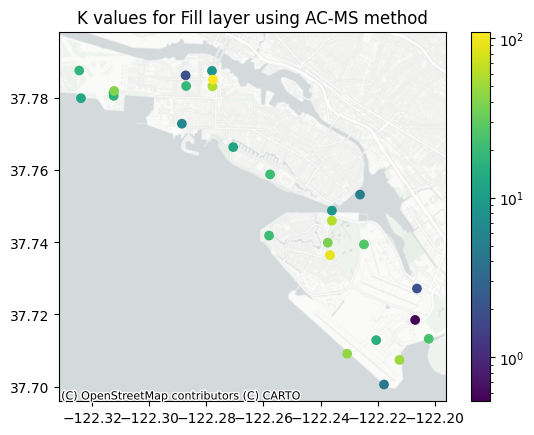

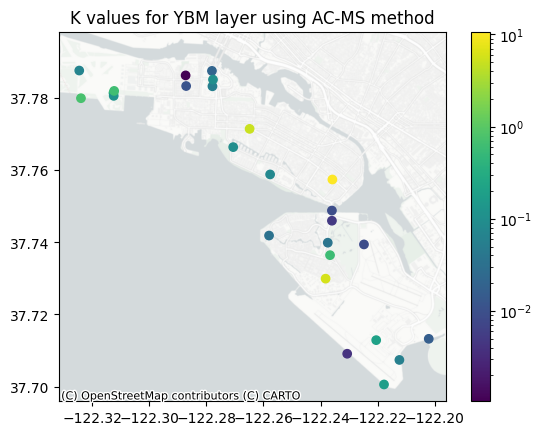

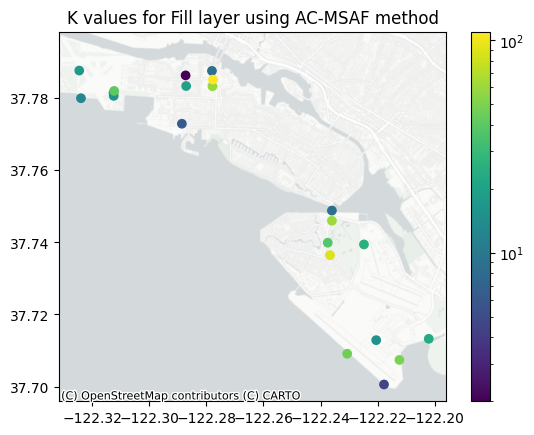

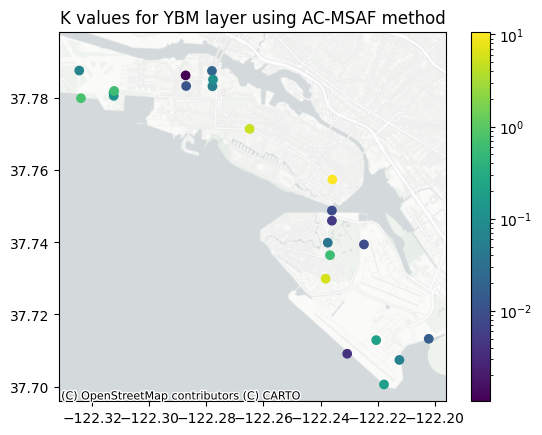

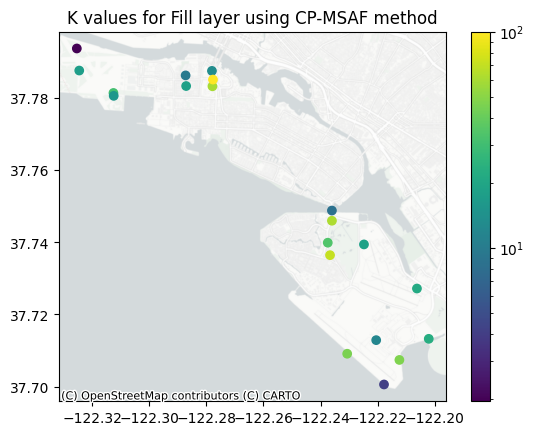

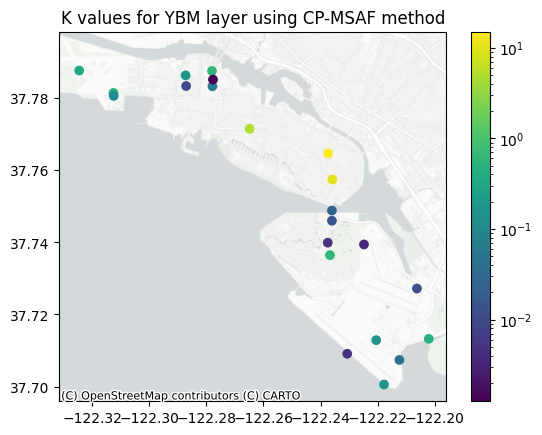

In [ ]:
# make the colorbar in log scale

fig = cpts_gdf.plot(column='AF_K_CP_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for Fill layer using CP-MS method')

fig = cpts_gdf.plot(column='YBM_K_CP_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YBM layer using CP-MS method')

fig = cpts_gdf.plot(column='AF_K_AC_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for Fill layer using AC-MS method')

fig = cpts_gdf.plot(column='YBM_K_AC_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YBM layer using AC-MS method')

fig = cpts_gdf.plot(column='AF_K_AC_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for Fill layer using AC-MSAF method')

fig = cpts_gdf.plot(column='YBM_K_AC_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YBM layer using AC-MSAF method')

fig = cpts_gdf.plot(column='AF_K_CP_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for Fill layer using CP-MSAF method')

fig = cpts_gdf.plot(column='YBM_K_CP_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YBM layer using CP-MSAF method')

Text(0.5, 1.0, 'K values for YB layer using AC-MSAF method')

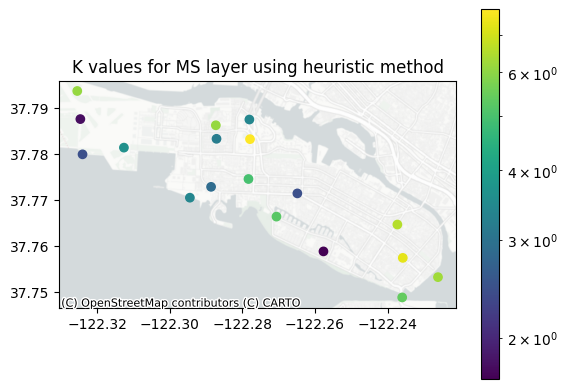

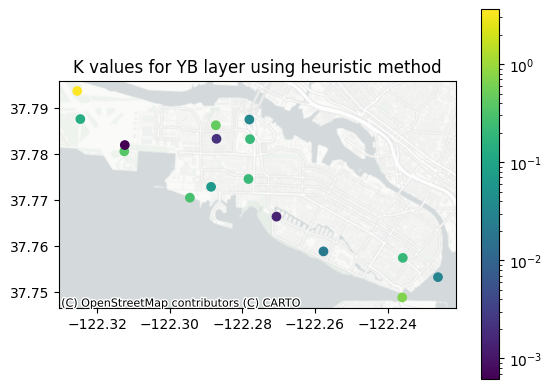

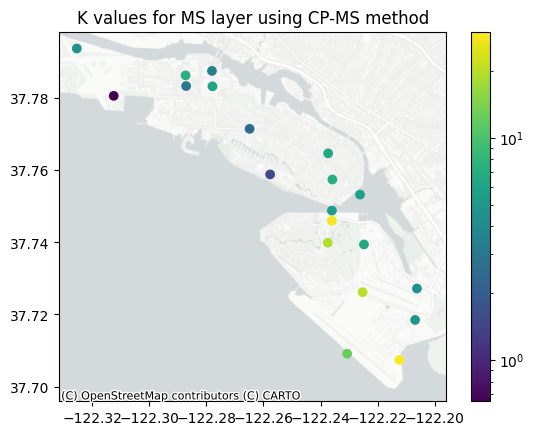

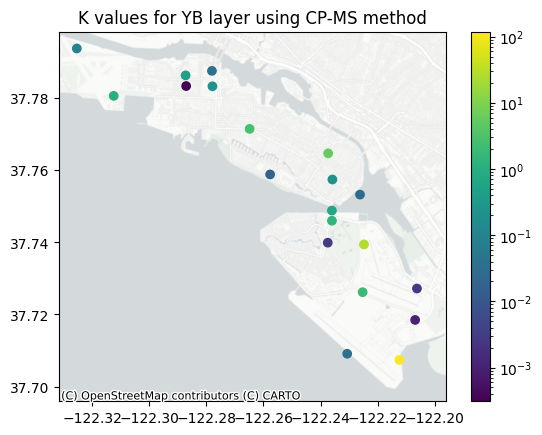

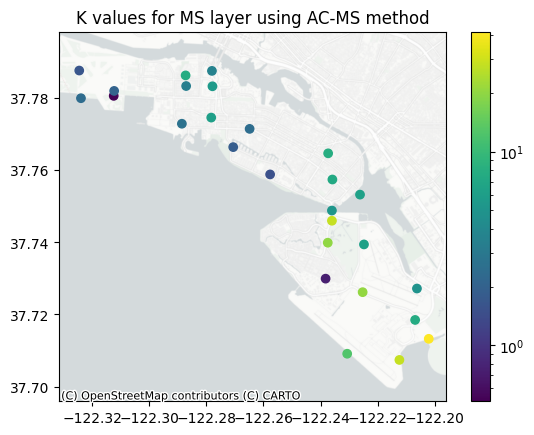

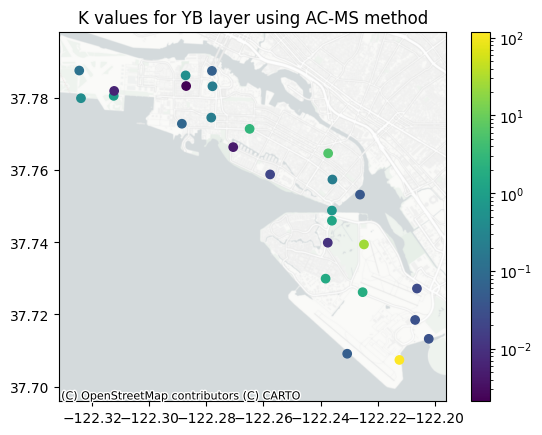

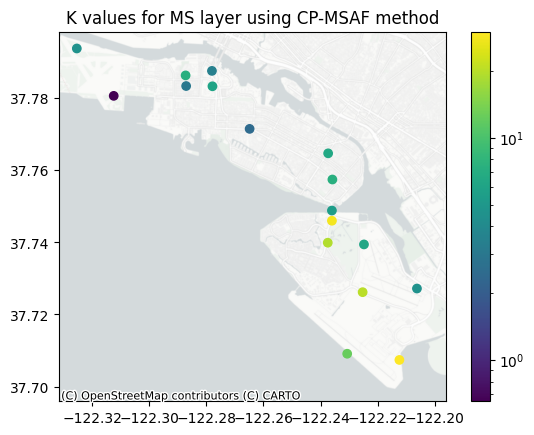

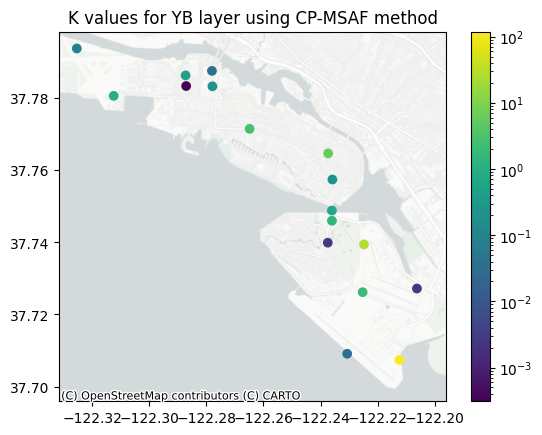

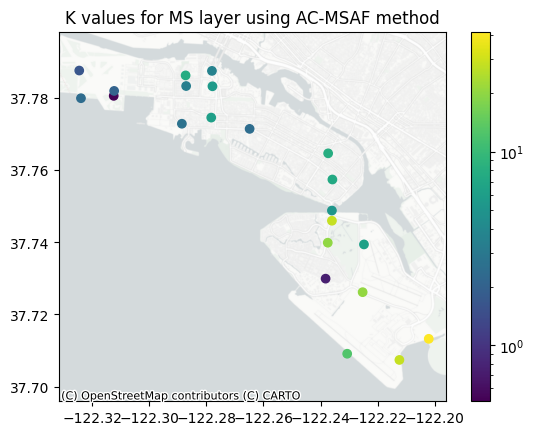

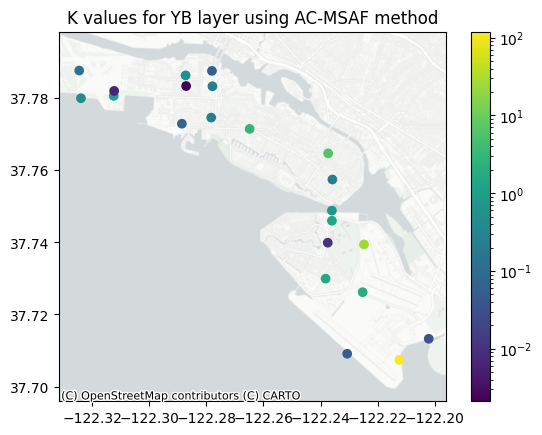

In [14]:
fig = cpts_gdf.plot(column='MS_K_heur', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for MS layer using heuristic method')

fig = cpts_gdf.plot(column='YB_K_heur', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YB layer using heuristic method')

fig = cpts_gdf.plot(column='MS_K_CP_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for MS layer using CP-MS method')

fig = cpts_gdf.plot(column='YB_K_CP_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YB layer using CP-MS method')

fig = cpts_gdf.plot(column='MS_K_AC_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for MS layer using AC-MS method')

fig = cpts_gdf.plot(column='YB_K_AC_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YB layer using AC-MS method')

fig = cpts_gdf.plot(column='MS_K_CP_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for MS layer using CP-MSAF method')

fig = cpts_gdf.plot(column='YB_K_CP_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YB layer using CP-MSAF method')

fig = cpts_gdf.plot(column='MS_K_AC_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for MS layer using AC-MSAF method')

fig = cpts_gdf.plot(column='YB_K_AC_MSAF', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for YB layer using AC-MSAF method')



MS_K_CP_MS


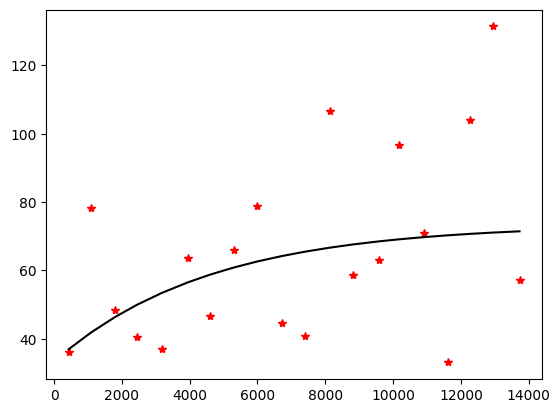

YB_K_CP_MS


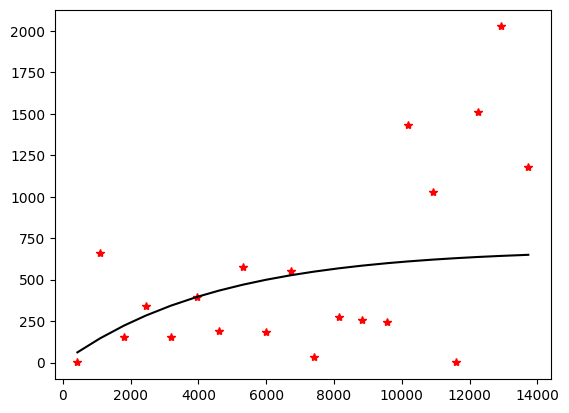

MS_K_AC_MS


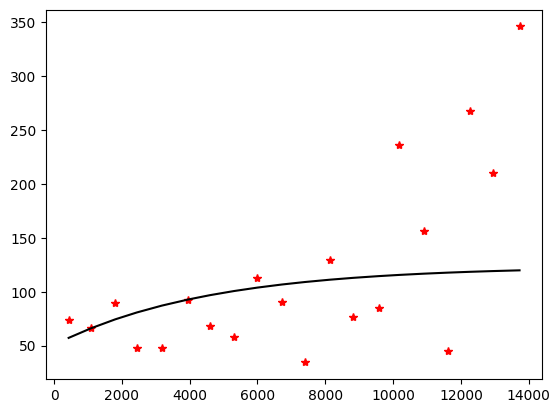

YB_K_AC_MS


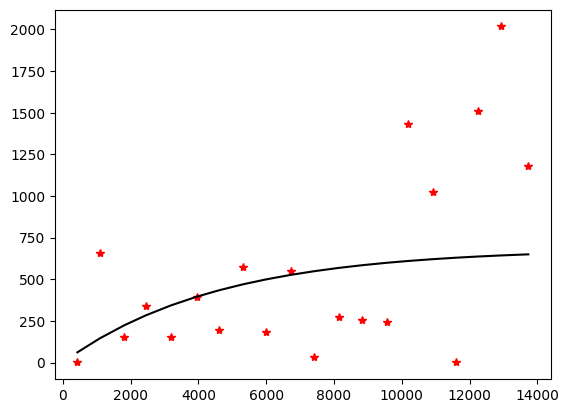

MS_K_AC_MSAF


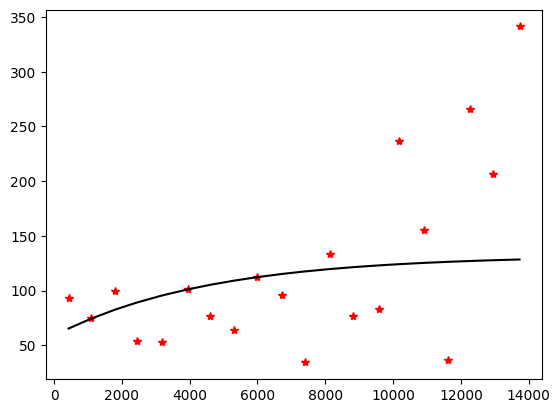

YB_K_AC_MSAF


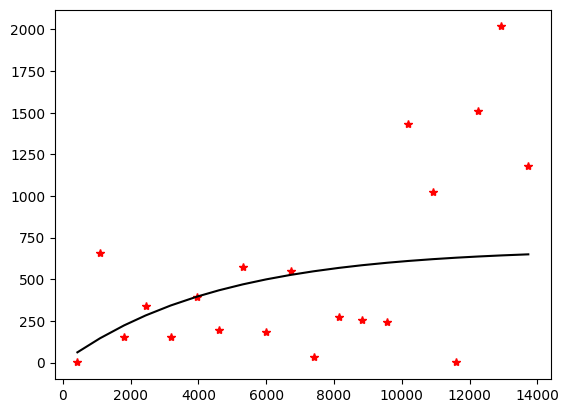

MS_K_CP_MSAF


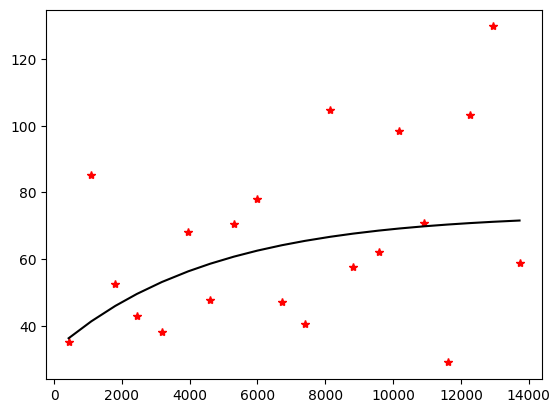

YB_K_CP_MSAF


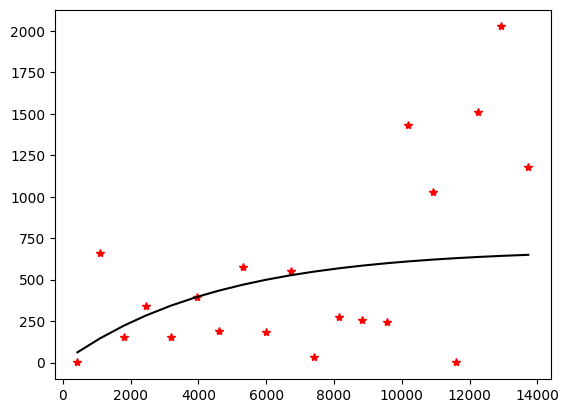

In [15]:
for k_layer in ['MS_K_CP_MS', 'YB_K_CP_MS', 'MS_K_AC_MS', 'YB_K_AC_MS', 'MS_K_AC_MSAF', 'YB_K_AC_MSAF', 'MS_K_CP_MSAF', 'YB_K_CP_MSAF']:
# Filter out rows with NaN in UTM coordinates or the depth column
    valid_layers = cpts_gdf.dropna(subset=['UTM-X', 'UTM-Y', k_layer])
    print(k_layer)
    # Extract valid coordinates and depth values
    x_coords = valid_layers['UTM-X'].values.astype(float)
    y_coords = valid_layers['UTM-Y'].values.astype(float)
    z_values = valid_layers[k_layer].values.astype(float)

    if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
        # Perform kriging
        kriging_model = OrdinaryKriging(
            x_coords, y_coords, z_values,
            variogram_model='exponential',
            verbose=False,
            nlags = 20, 
            enable_plotting=True
        )

AF_K_CP_MS


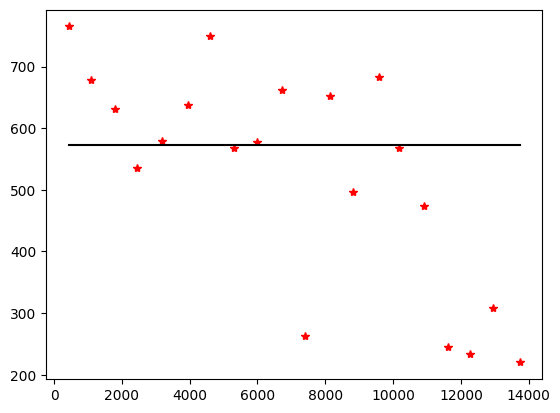

YBM_K_CP_MS


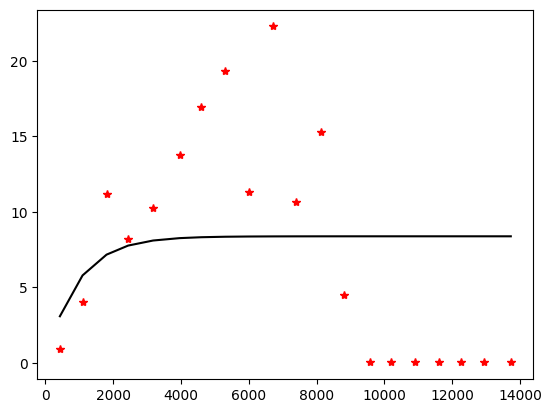

AF_K_AC_MS


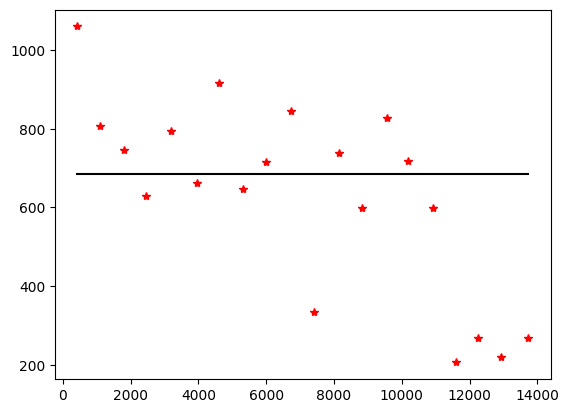

YBM_K_AC_MS


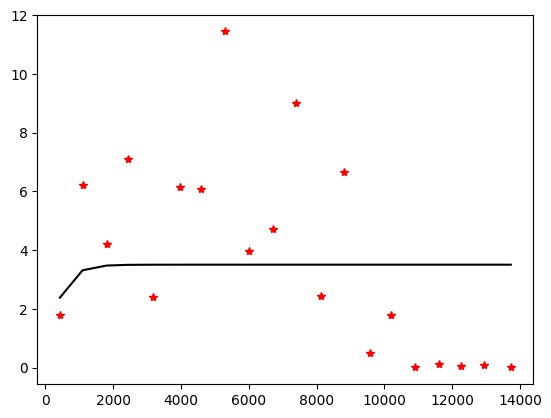

AF_K_AC_MSAF


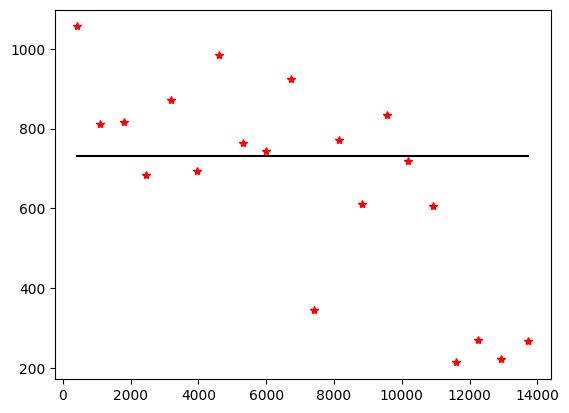

YBM_K_AC_MSAF


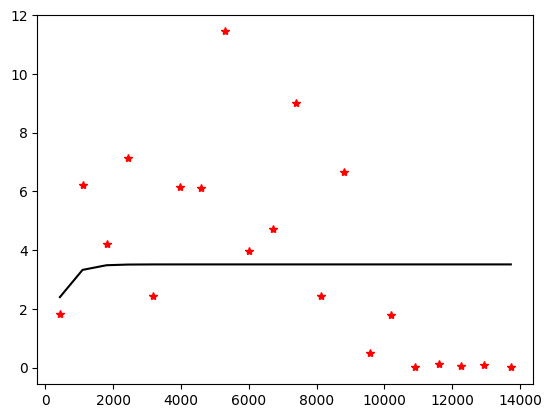

AF_K_CP_MSAF


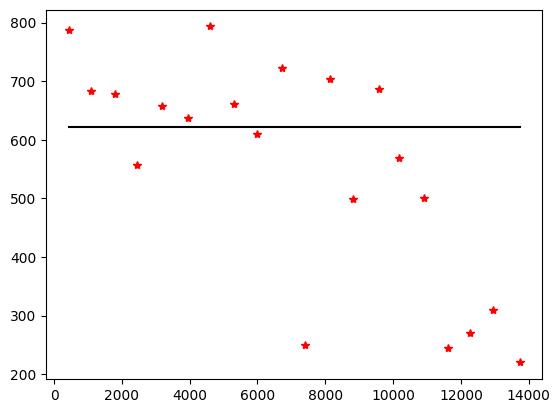

YBM_K_CP_MSAF


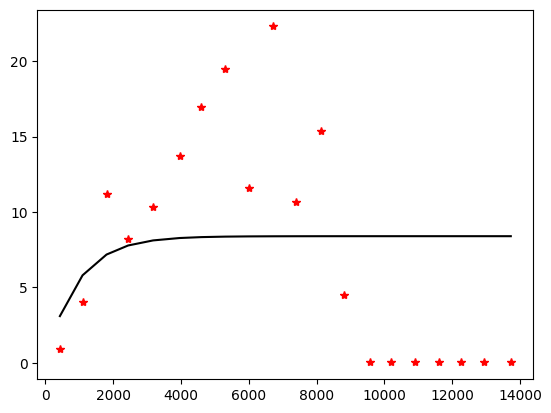

In [ ]:
## okay, now, try fitting a variogram to the data
k_layer = 'AF_K_CP_MS'
for k_layer in ['AF_K_CP_MS', 'YBM_K_CP_MS', 'AF_K_AC_MS', 'YBM_K_AC_MS', 'AF_K_AC_MSAF', 'YBM_K_AC_MSAF', 'AF_K_CP_MSAF', 'YBM_K_CP_MSAF']:
# Filter out rows with NaN in UTM coordinates or the depth column
    valid_layers = cpts_gdf.dropna(subset=['UTM-X', 'UTM-Y', k_layer])
    print(k_layer)
    # Extract valid coordinates and depth values
    x_coords = valid_layers['UTM-X'].values.astype(float)
    y_coords = valid_layers['UTM-Y'].values.astype(float)
    z_values = valid_layers[k_layer].values.astype(float)

    if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
        # Perform kriging
        kriging_model = OrdinaryKriging(
            x_coords, y_coords, z_values,
            variogram_model='exponential',
            verbose=False,
            nlags = 20, 
            enable_plotting=True
        )


#### Try checking for a spatial trend on just Alameda, excluding bay farm island

In [ ]:
# find only where the index of cpts_gdf starts with ALC
cpts_gdf_ALC = cpts_gdf[cpts_gdf.index.str.startswith('ALC')]


,Date,UTM-X,UTM-Y,Elev,Water depth,Lat,Lon,SBT,SBT_descr,SBT_inv,...,MS_K_AC_MSAF,YB_K_AC_MSAF,AF_K_CP_MSAF,YBM_K_CP_MSAF,MS_K_CP_MSAF,YB_K_CP_MSAF,AF_K_heur,YBM_K_heur,MS_K_heur,YB_K_heur
ALC007,2000-12-07,567309,4177908,0.5,0.50,37.745995,-122.235993,"[7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 6.0, ...","[Dense sand to gravelly sand, Dense sand to gr...","[0.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, ...",...,28.017466,1.397011,61.574375,0.014175,28.017466,1.397011,NaN,NaN,NaN,NaN
ALC008,2000-12-07,567306,4178221,1.0,1.00,37.748816,-122.235998,"[7.0, 7.0, 6.0, 6.0, 6.0, 5.0, 6.0, 5.0, 5.0, ...","[Dense sand to gravelly sand, Dense sand to gr...","[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, ...",...,5.200471,0.682703,8.475197,0.025441,5.389092,0.682703,114.095139,1.678742,5.389092,0.682703
ALC009,2000-12-08,563586,4182014,1.5,1.40,37.783267,-122.277889,"[5.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[Sand mixtures: silty sand to sandy silt, Dens...","[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, ...",...,5.517902,0.203258,59.562120,0.060097,6.062656,0.214589,98.768154,0.220661,7.773931,0.214589
ALC010,2000-12-08,562774,4182016,1.5,1.40,37.783341,-122.287109,"[7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, ...","[Dense sand to gravelly sand, Sands: clean san...","[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 2.0, 2.0, ...",...,3.282937,0.002117,18.329881,0.010326,3.018044,0.000310,43.699600,0.063067,3.202428,0.002117
ALC011,2000-12-08,562755,4182343,1.5,1.40,37.786290,-122.287297,"[7.0, 6.0, 6.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, ...","[Dense sand to gravelly sand, Sands: clean san...","[0.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",...,7.607349,0.465342,9.780087,0.165707,7.303058,0.465342,9.780087,0.166190,6.094710,0.471539
ALC012,2001-01-12,567186,4177231,1.0,1.40,37.739903,-122.237451,"[5.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[Sand mixtures: silty sand to sandy silt, Dens...","[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, ...",...,20.109786,0.010029,33.975438,0.005109,19.191393,0.002686,NaN,NaN,NaN,NaN
ALC013,2001-01-12,563567,4182488,1.5,1.70,37.787540,-122.278063,"[7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, ...","[Dense sand to gravelly sand, Sands: clean san...","[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 2.0, 2.0, ...",...,3.556830,0.057990,12.948095,0.644753,3.410036,0.036821,18.008843,0.630231,3.410036,0.036821
ALC014,2001-01-12,563601,4182221,1.5,1.20,37.785132,-122.277700,"[7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[Dense sand to gravelly sand, Dense sand to gr...","[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, ...",...,0.000000,0.000000,100.257930,0.001251,0.000000,0.000000,100.257930,0.001226,0.000000,0.000000
ALC015,2001-01-24,560531,4181786,1.5,0.10,37.781420,-122.312599,"[3.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, ...","[Clays: clay to silty clay, Sand mixtures: sil...","[0.0, 0.0, 2.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, ...",...,0.000000,0.000000,31.070316,0.466911,0.000000,0.000000,30.477313,0.316887,3.643413,0.000000
ALC016,2001-01-24,560540,4181697,1.5,1.10,37.780617,-122.312505,"[7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[Dense sand to gravelly sand, Dense sand to gr...","[0.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",...,0.515254,0.941587,15.695063,0.110718,0.652082,1.001161,50.726406,0.867407,0.000000,0.367615


Text(0.5, 1.0, 'K values for MS layer using CP-MS method')

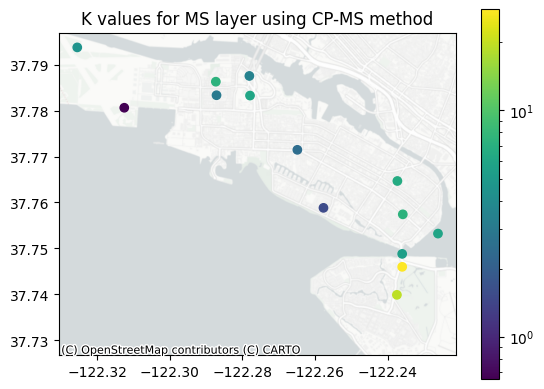

In [20]:
fig = cpts_gdf_ALC.plot(column='MS_K_CP_MS', legend=True, norm=LogNorm())
ctx.add_basemap(fig, source=ctx.providers.CartoDB.PositronNoLabels, crs = cpts_gdf.crs)
plt.title('K values for MS layer using CP-MS method')

MS_K_CP_MS


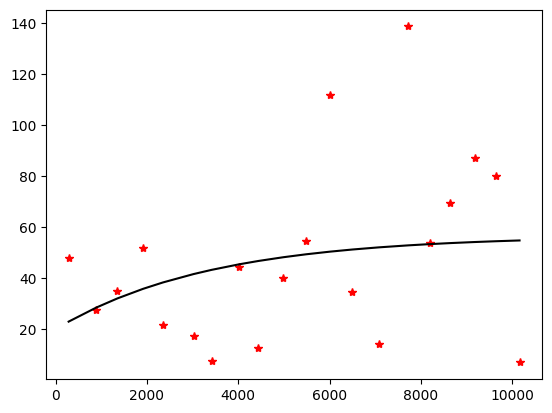

YB_K_CP_MS


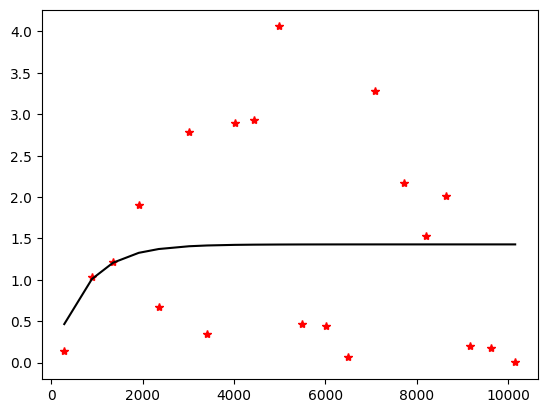

MS_K_AC_MS


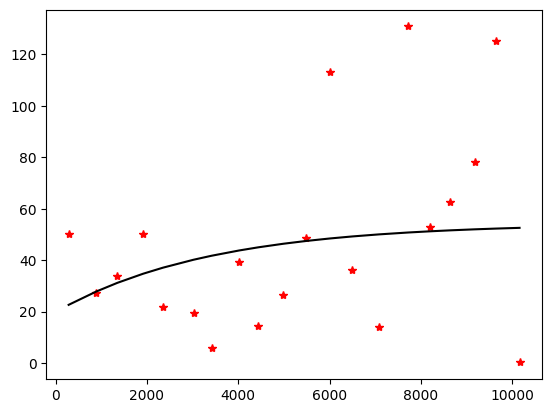

YB_K_AC_MS


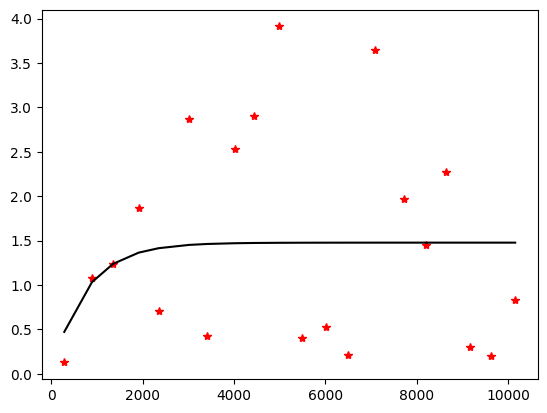

MS_K_AC_MSAF


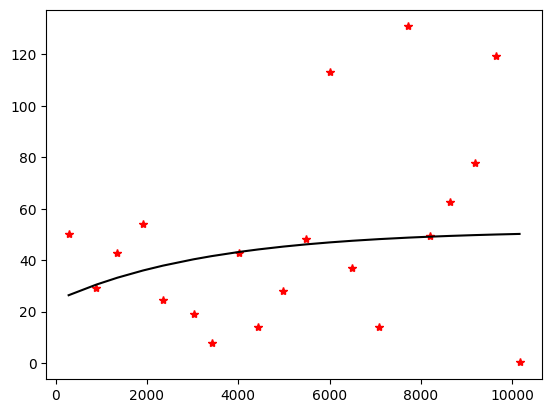

YB_K_AC_MSAF


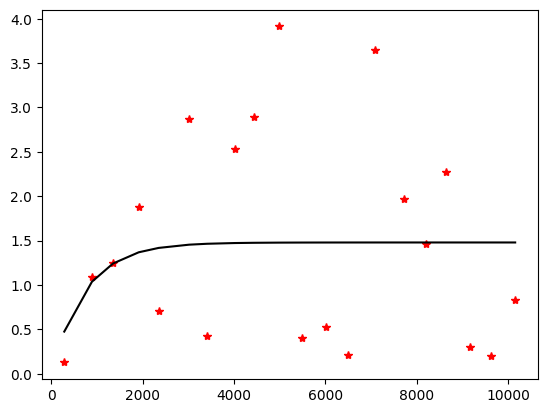

MS_K_CP_MSAF


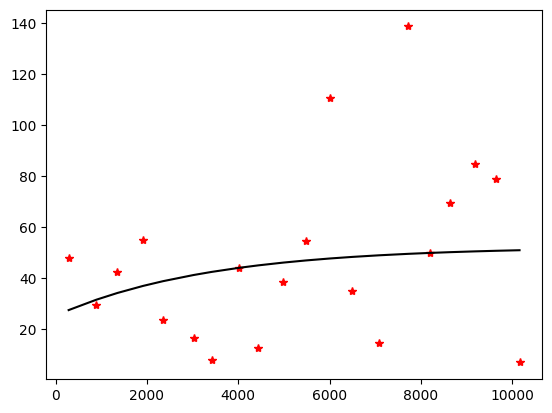

YB_K_CP_MSAF


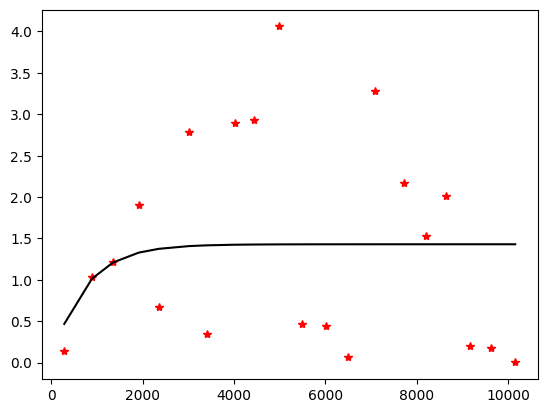

In [18]:
for k_layer in ['MS_K_CP_MS', 'YB_K_CP_MS', 'MS_K_AC_MS', 'YB_K_AC_MS', 'MS_K_AC_MSAF', 'YB_K_AC_MSAF', 'MS_K_CP_MSAF', 'YB_K_CP_MSAF']:
# Filter out rows with NaN in UTM coordinates or the depth column
    valid_layers = cpts_gdf_ALC.dropna(subset=['UTM-X', 'UTM-Y', k_layer])
    print(k_layer)
    # Extract valid coordinates and depth values
    x_coords = valid_layers['UTM-X'].values.astype(float)
    y_coords = valid_layers['UTM-Y'].values.astype(float)
    z_values = valid_layers[k_layer].values.astype(float)

    if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
        # Perform kriging
        kriging_model = OrdinaryKriging(
            x_coords, y_coords, z_values,
            variogram_model='exponential',
            verbose=False,
            nlags = 20, 
            enable_plotting=True
        )